# Assembler AArch64

Посмотрим, чем отличается AArch64 от x86. AArch64 - RISC архитектура, x86 - CISC. Подробнее - в слайдах лекции!

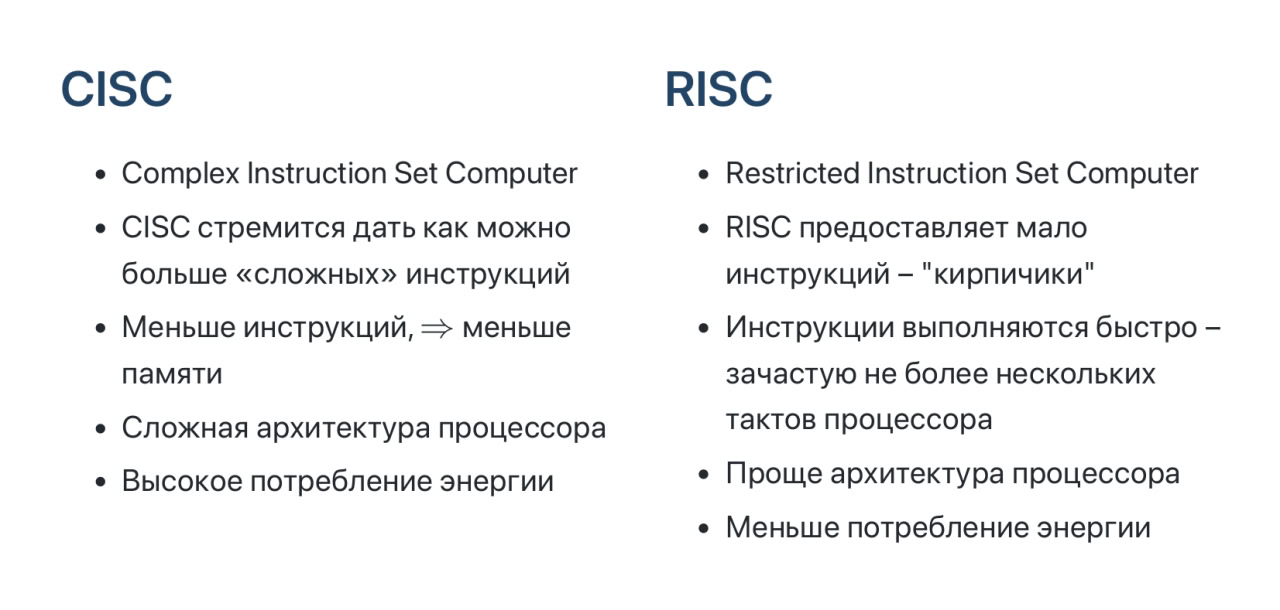

## <a name="install_instr"></a> Установка инструментов
1) Устанавливаем компилятор:
```
 sudo apt update && sudo apt upgrade
 sudo apt --fix-broken install
 sudo apt-get install gcc-aarch64-linux-gnu
  
```
2) Устанавливаем эмулятор
```
sudo apt-get install qemu-system-arm
sudo apt-get install qemu-efi-aarch64
sudo apt-get install qemu-utils
sudo apt install qemu-user
```

## <a name="compile_run"></a> Компиляция и запуск
1) Примеры компиляции:
* `aarch64-linux-gnu-gcc main.c -o programme.exe`
* `aarch64-linux-gnu-gcc main.S -o programme.exe`
* `aarch64-linux-gnu-gcc main.c lib.S -o programme.exe`
* `aarch64-linux-gnu-gcc -S -O3 lib.c -o lib.S`

2) Запуск:
```
qemu-aarch64 -L /usr/aarch64-linux-gnu ./programme.exe
```
Чтобы не прописывать каждый раз `-L /usr/aarch64-linux-gnu`, можно установить переменную окружения:
```
export QEMU_LD_PREFIX=/usr/aarch64-linux-gnu
qemu-aarch64 ./programme.exe
```

**Самое основное**:
* Есть регистры и есть память
* Стек тоже память и он растет вниз
* Есть инструкции для операций с регистрами `ADD`, `MUL`, `CMP`, ...
* Есть инструкции условных и безусловных переходов (на самом деле те же операции с регистрами). `B`, `BL`, `BX`, `BGT`...
* Есть инструкции, для взаимодействия с памятью `LDR`, `STR`

## Регистры
Названия регистров:
* `r0-r30` - общее обращение к регистрам
* `x0-x30` - обращение к 64-битным регистрам (те же регистры, что и `r0-r30`)
* `w0-w30` - обращение к 32-битной половине регистра

## Основное из Calling Conventions
* Первые 4 аргумента функции принимаются через `r0`..`r3`, остальные через стек
* После вызова функции (вашей или не вашей) значения `r4`-`r8`, `r10`, `r11` не должны изменяться. (Функция может их использовать, но обязана восстановить прежние значения) 
* `r9`, `r12`-`r15` имеют специальное значение, проще их не использовать
* `pc` - в этом регистре хранится адрес текущей инструкции, его изменение - то же самое, что безусловный переход
* `sp` - указатель на стек
* `lr` - адрес возврата

## Инструкции
Полный перечень 32-битных команд см. в [этом reference](https://github.com/victor-yacovlev/fpmi-caos/blob/master/practice/asm/arm_basics/arm_reference.pdf), начиная со 151 страницы.

Архитектура ARM-32 подразумевает, что почти все команды могут иметь *условное выполнение*. Условие кодируется 4-мя битами в самой команде, а с точки зрения синтаксиса ассемблера у команд могут быть суффиксы.

Таким образом, каждая команда состоит из двух частей (без разделения пробелами): сама команда и её суффикс.

### Базовые арифметические операции

* `AND regd, rega, argb`  // regd ← rega & argb
* `EOR regd, rega, argb`  // regd ← rega ^ argb
* `SUB regd, rega, argb`  // regd ← rega − argb
* `RSB regd, rega, argb`  // regd ← argb - rega
* `ADD regd, rega, argb`  // regd ← rega + argb
* `ADC regd, rega, argb`  // regd ← rega + argb + carry
* `SBC regd, rega, argb`  // regd ← rega − argb − !carry
* `RSC regd, rega, argb`  // regd ← argb − rega − !carry
* `TST rega, argb`        // set flags for rega & argb
* `TEQ rega, argb`        // set flags for rega ^ argb
* `CMP rega, argb`        // set flags for rega − argb
* `CMN rega, argb`        // set flags for rega + argb
* `ORR regd, rega, argb`  // regd ← rega | argb
* `MOV regd, arg`         // regd ← arg
* `BIC regd, rega, argb`  // regd ← rega & ~argb
* `MVN regd, arg`         // regd ← ~argb

### Суффиксы-условия

```
EQ        equal  (Z)
NE        not equal  (!Z)
CS or HS  carry set / unsigned higher or same  (C)
CC or LO  carry clear / unsigned lower  (!C)
MI        minus / negative  (N)
PL        plus / positive or zero  (!N)
VS        overflow set  (V)
VC        overflow clear  (!V)
HI        unsigned higher  (C && !Z)
LS        unsigned lower or same  (!C || Z)
GE        signed greater than or equal  (N == V)
LT        signed less than  (N != V)
GT        signed greater than  (!Z && (N == V))
LE        signed less than or equal  (Z || (N != V))
```

### Переходы

Счетчик `pc` автоматически увеличивается на 4 при выполнении
очередной инструкции. Для ветвления программ изпользуются команды:

 * `B label` - переход на метку; используется внутри функций для ветвлений, связанных с циклами или условиями
 * `BL label` - сохранение текущего `pc` в `lr` и переход на `label`; обычно используется для вызова функций
 * `BX register` - переход к адресу, указанному в регистре; обычно используется для выхода из функций.

### Работа с памятью

Процессор может выполнять операции только над регистрами. Для взаимодействия с памятью используются отдельные инструкции загрузки/сохранения регистров.

* `LDR regd, [regaddr]` - загружает машинное слово из памяти по адресу, хранящимся в regaddr, и сохраняет его в регистре regd
* `STR reds, [regaddr]` - сохраняет в памяти машинное слово из регистра regs по адресу, указанному в регистре regaddr.

### Полезные фишки (но только для ARM32)

`cmp r0, #'9'` - так можно писать char-константы

`push {r4, r5, r6, r7, r8, lr}` <-> `push {r4-r8, lr}`


`str r0, [r1, #4]! (C-style: *(r1 += 4) = r0)` - то же самое, что и `str r0, [r1, #4] (C-style: *(r1 + 4) = r0)`, но в `r1`, будет сохранено `r1 + #4` после выполнения команды. Другими словами префиксный инкремент на 4.

`ldr r0, [r1], #4` - то же самое, что и `ldr r0, [r1] (C-style: r0 = *r1)` с последующим `add r1, r1, #4 (C-style: r1 += 4)`. Другими словами постфиксный инкремент.

В ARM64 нет инструкций `push` и `pop` : [почитать](https://stackoverflow.com/questions/78404268/how-to-use-stack-in-arm64-assembly)



## Пример с дисассемблером и сравнениями

In [3]:
%%bash
cat compare.c

long long func(long long x, long long y) {
    if (x < y) {
        return y + 7;
    }
    if (x == y + 1) {
        return 21;
    }
    return x + y;
}


In [5]:
%%bash
aarch64-linux-gnu-gcc -S -Os compare.c -o compare.S

Код из `compare.S` с комментариями:
```
	.arch armv8-a
	.file	"compare.c"
	.text
	.align	2
	.global	func
	.type	func, %function
func:
.LFB0:
	.cfi_startproc
	cmp	x0, x1       \\ сравниваем x и y
	bge	.L2          \\ если x >= y, то прыгаем на метку .L2
	add	x0, x1, 7    \\ если x < y, то складываем в x0 значение y+7
.L1:
	ret
.L2:
	add	x2, x1, 1         \\ кладем в x2 значение y+1
	add	x1, x0, x1        \\ кладем в x1 значение x+y
	cmp	x2, x0            \\ сравниваем x и y
	mov	x0, 21            \\ складываем в x0 значение 21
	csel	x0, x1, x0, ne   \\ x0 = ne ? x1 : x0 (conditional select)
	b	.L1                 \\ вместо этого можно было бы написать ret
	.cfi_endproc
.LFE0:
	.size	func, .-func
	.ident	"GCC: (Ubuntu 11.2.0-5ubuntu1) 11.2.0"
	.section	.note.GNU-stack,"",@progbits

```

## Пример с указателями и памятью

In [6]:
%%bash
cat pointer.c

#include <inttypes.h>

char compare_and_exchange(int64_t* contained, int64_t* expected, int64_t value) {
    if (*contained == *expected) {
        *contained = value;
        return 1;
    }
    *expected = *contained;
    return 0;
}


In [8]:
%%bash
aarch64-linux-gnu-gcc -S -Os pointer.c -o pointer.S

Разбор того, что делает код `pointer.S`:

```
	.arch armv8-a
	.file	"pointer.c"
	.text
	.align	2
	.global	compare_and_exchange
	.type	compare_and_exchange, %function
compare_and_exchange:
.LFB0:
	.cfi_startproc
	ldr	x3, [x0]  // x3 = *(contained)
	ldr	x4, [x1]  // x4 = *(expected)
	cmp	x3, x4    // сравниваем *contained и *expected
	bne	.L2       // если не равны, то прыгаем на .L2
	str	x2, [x0]  // *(contained) = value
	mov	w0, 1     // w0 = 1
.L3:
	ret
.L2:
	mov	w0, 0      // w0 = 0
	str	x3, [x1]   // *expected = *contained
	b	.L3          // вместо этого можно было написать ret
	.cfi_endproc
.LFE0:
	.size	compare_and_exchange, .-compare_and_exchange
	.ident	"GCC: (Ubuntu 11.2.0-5ubuntu1) 11.2.0"
	.section	.note.GNU-stack,"",@progbits
```

## Пример с вызовом функции
Напишем на ассемблере реализацию следующей функции:

In [10]:
%%file func_call.c

#include <inttypes.h>
#include <stdio.h>

int64_t get_int64() {
    int64_t var = 0;
    scanf("%ld", &var);
    return var;
}

Overwriting func_call.c


In [13]:
%%file func_call.S

    .text
    .global get        // делаем функцию get глобальной
    
get:
    sub sp, sp, 16     // sp -= 16, аллоцируем 16 байт на стеке
    
    str lr, [sp, 8]    // сохраняем адсрес возврата по адресу sp+8
    
    adr x0, format_str // сохраняем адрес format_str в x0
    
    mov x1, sp         // x1 = sp - адрес int64_t для записи прочитанного в scanf

    bl scanf           // вызов scanf
    
    ldr x0, [sp]       // загружаем прочитанное значение в x0
    
    ldr lr, [sp, 8]    // восстанавливаем значение lr
    
    add sp, sp, 16     // освобождаем ранее выделенную память на стеке
    
    ret
    
    .section .rodata
format_str:
    .string "%ld"

Overwriting func_call.S


## Как тестировать ассемблерный код

Давайте протестируем функцию `get`, реализованную в `func_call.S`. Для этого вызовем ее из кода на C.

In [35]:
%cat main.c

#include <stdio.h>
#include <stdint.h>

int64_t get();

int main()  {
    int64_t read = get();

    printf("Got: %ld\n", read);
}


`int64_t get()` - объявление функции, определение находится в `func_call.S`.

Скомпилировать и запустить это можно так:
```
aarch64-linux-gnu-gcc func_call.S main.c -o main
qemu-aarch64 main
```